# test roll out predictions with GP

In [2]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import os
from link_bot_gaussian_process import link_bot_gp, data_reformatting
from link_bot_pycommon import link_bot_pycommon, link_bot_sdf_utils
from link_bot_data.multi_environment_datasets import MultiEnvironmentDataset
import tensorflow as tf
from IPython.display import HTML
import warnings
from matplotlib import animation
import gpflow as gpf
import h5py

tf.logging.set_verbosity(tf.logging.ERROR)
np.set_printoptions(suppress=True, precision=4, linewidth=200)
plt.style.use("slides")
plt.style.use("slides")


Using TensorFlow backend.


In [3]:
sdf, _, _, _ = link_bot_sdf_utils.load_sdf("/home/pmitrano/catkin_ws/src/link_bot/link_bot_data/data/sdfs/empty_sdf.npz")
extent = [-5, 5, -5, 5]

In [4]:
gp_model_dir = '/home/pmitrano/catkin_ws/src/link_bot/link_bot_gaussian_process/log_data/no_obj/September_15_10-19-40_5d1df5dd1e/'

# gpf.reset_default_graph_and_session()
# gpf.reset_default_session()
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=False, per_process_gpu_memory_fraction=0.1))
gpf.reset_default_graph_and_session(config=config)

fwd_gp_model = link_bot_gp.LinkBotGP()
fwd_gp_model.load(os.path.join(gp_model_dir, 'fwd_model'))

# inv_gp_model = link_bot_gp.LinkBotGP()
# inv_gp_model.load(os.path.join(gp_model_dir, 'inv_model'))

Loading model from /home/pmitrano/catkin_ws/src/link_bot/link_bot_gaussian_process/log_data/no_obj/September_15_10-19-40_5d1df5dd1e/fwd_model


/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [5]:
initial_config = np.array([[0.5, 0.5, 0.5, 0, 0, 0]])
steps = 100
vx = -0.3
vy = 0.3
controls =  np.tile([vx,vy], [steps, 1])
durations = np.ones(steps, dtype=np.int)
prediction, variances = link_bot_gp.predict(fwd_gp_model, initial_config, controls, durations)
anim = link_bot_gp.animate_predict(prediction, sdf, arena_size=5, linewidth=2)
plt.close()
HTML(anim.to_jshtml())

In [14]:
anim.save('new_gp_prediction_{}.mp4'.format(int(time())), writer='imagemagick')

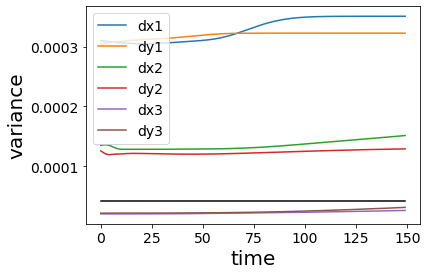

In [6]:
plt.figure()
plt.plot(variances[:, 0], label='dx1')
plt.plot(variances[:, 1], label='dy1')
plt.plot(variances[:, 2], label='dx2')
plt.plot(variances[:, 3], label='dy2')
plt.plot(variances[:, 4], label='dx3')
plt.plot(variances[:, 5], label='dy3')
plt.plot(np.linalg.norm(controls * 1e-4, axis=1), color='k')
plt.xlabel("time")
plt.ylabel("variance")
plt.legend();

In [7]:
inv_gp_model.initialize_rng(1, 100)

In [8]:
test_dataset = MultiEnvironmentDataset.load_dataset("./data/gz_test_231723146d_50_100/dataset.json")
env = test_dataset.environments[0]
rope_configurations = env.rope_data['rope_configurations']

In [9]:
print(rope_configurations[0])
print(rope_configurations[10])

[ 0.5959 -0.3144  1.0759 -0.313   1.5552 -0.2875]
[ 0.4017 -0.3722  0.8779 -0.3121  1.275  -0.0424]


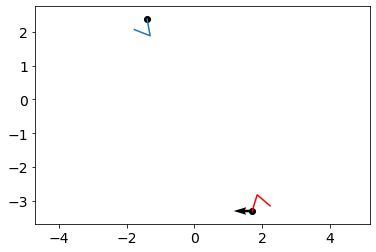

In [10]:
s = np.expand_dims(rope_configurations[0], axis=0)
s_target = np.expand_dims(rope_configurations[24], axis=0)
s = np.array([[2, -1, 2.5, -1, 2.5, -1.5]])
s_target = np.array([[0, 0, 0.5, 0, .5, 0.5]])
s = np.expand_dims(link_bot_pycommon.make_random_rope_configuration(extent), axis=0)
s_target = np.expand_dims(link_bot_pycommon.make_random_rope_configuration(extent), axis=0)
u, _ = inv_gp_model.inv_act(s, s_target)
plt.plot([s[0, 0], s[0, 2], s[0, 4]], [s[0,1], s[0,3], s[0,5]], c='r')
plt.plot([s_target[0, 0], s_target[0, 2], s_target[0, 4]], [s_target[0,1], s_target[0,3], s_target[0,5]])
plt.scatter([s[0, 4], s_target[0,4]], [s[0,5], s_target[0,5]], c='k')
plt.quiver(s[0,4], s[0,5], u[0,0], u[0,1])
plt.axis("equal");

In [11]:
156038/14380

10.851043115438108

In [12]:
21972/14401

1.5257273800430526